# Age recognition 

**Authors**: Richard Šléher, Tomáš Majerník

**Dataset**: https://www.kaggle.com/datasets/arashnic/faces-age-detection-dataset/code?select=train.csv

# TODO
- natrenovat
- pripravit valid/test dataset 
- wandb
- pozret sa ci treba zmenit weighty ked mame pre nejaku classu viac obrazkov aby castejsie classificovalo

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from summarytools import dfSummary
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import torch.optim as optim
import torch.nn as nn

Hyperparameters

In [2]:
IMAGE_SIZE = 224
epoch = 30
batch_size = 32
lr = 0.1e-4

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## EDA

In [4]:
data = pd.read_csv('data/train.csv')

In [5]:
dfSummary(data)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,ID[object],1. 9896.jpg2. 377.jpg3. 7038.jpg4. 10812.jpg5. 11803.jpg6. 22630.jpg7. 9733.jpg8. 6149.jpg9. 10025.jpg10. 14939.jpg11. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)19,896 (99.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,Class[object],1. MIDDLE2. YOUNG3. OLD,"10,804 (54.3%)6,706 (33.7%)2,396 (12.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABmUlEQVR4nO3bMWrjYBSF0adBhKSRMAYvxouYxc4itBtjrCIJaZQiXYY4jeZK8+ecFTybDxsZ325ZloKEX1sfwM/RVdVTVT1sfUhD3pZledn6iD3qj8fj72EYDlsf0op5nq9d1/0R3N/6YRgO5/P5ZRzH162P+d/dbrfHaZoOl8vloarE9klfVTWO4+vpdHre+phGPG19wF55QCBGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGTF/18T+srQ9pgffxvn6e5+s0TYfyP6xVzPN8raq3re/YIxuE9dkgfKEz5SOlxU82nyw71dy6yrppv5paV1k37VuL6ypP1TvlR11ixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxDS1rmrldbSquXWVddN+2SAQY11FjAcEYtb+GvUVxpdWnfKZ0XHPalM+Mzq+s/aUr4mfT/g3PCAQIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2a1KZ8ZHd9ZdcpnRsc9NgjEmPIR8w5KvKNKilfZywAAAABJRU5ErkJggg=="">",0(0.0%)


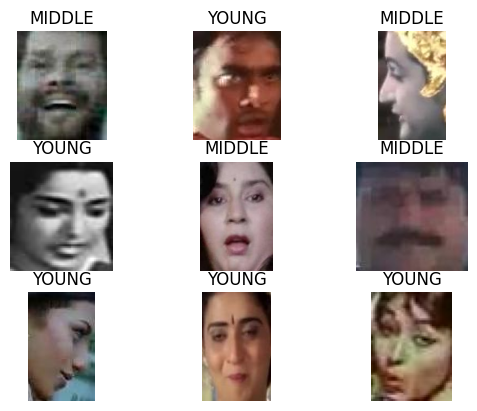

In [6]:
fig = plt.figure()

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread('data/train/' + data.iloc[i]['ID'])
    plt.imshow(img)
    plt.title(data.iloc[i]['Class'])
    plt.axis('off')

plt.show()

In [ ]:
def load_data(dataframe: pd.DataFrame, directory: str, transform: transforms.Compose):
    if not os.path.exists(directory):
        os.makedirs(directory)

    images = []
    labels = []
    label_mapping = {'YOUNG': 0, 'MIDDLE': 1, 'OLD': 2}

    for idx in range(len(dataframe)):
        img_name = os.path.join(directory, dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = dataframe.iloc[idx, 1]
        if transform:
            transformed_image = transform(image)
        images.append(transformed_image)
        labels.append(label_mapping[label])

    return torch.stack(images).to(device), torch.tensor(labels).to(device)

In [8]:
def calculate_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    mean = 0.0
    std = 0.0
    total_images_count = 0
    
    for images, _ in loader:
        images = images.view(batch_size, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_size
    
    mean /= total_images_count
    std /= total_images_count
    
    return mean, std

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

valid_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_images, train_labels = load_data(data, 'data/Train/', train_transform)
#valid_images, valid_labels = load_data(valid_df, 'data/Test/', valid_test_transform)

train_loader = [(train_images[i:i + batch_size], train_labels[i:i + batch_size]) for i in range(0, len(train_images), batch_size)]
#valid_loader = [(valid_images[i:i + batch_size], valid_labels[i:i + batch_size]) for i in range(0, len(valid_images), batch_size)]

# Shape of the data for DL model
for images, labels in train_loader:
    print(images.shape, len(labels))
    break

In [ ]:
for images, labels in train_loader:
    print(labels)
    break

## Model

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes: int):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
# Example usage:
model = VGG16(num_classes=3)
print(model)

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(epoch):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epoch}, Loss: {running_loss/len(train_loader)}")

print("Training finished.")